In [189]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader

import logging

import gpytorch
import gpytorch.kernels as kernels
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.utils.cholesky import psd_safe_cholesky
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints import GreaterThan
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.priors import LogNormalPrior

from time_series_generator import SyntheticTimeSeriesGenerator
from time_series_dataset import TimeSeriesDataset


from gp_kernel_factory import KernelBuilder

from curriculum_selector import CurriculumSelector

from inducing_point_sampler import InducingPointSampler
from variational_gp_model import VariationalGPModel

from exact_gp_model import ExactGPModel

from gp_trainer import GPTrainer
from gp_utils import extract_latent_components

from exact_gp_trainer import ExactGPTrainer
from frozen_kernel_predictor import FrozenKernelPredictor

import gp_plotting as gpplt

import matplotlib.pyplot as plt


# new solution

# prod

In [120]:
# Generate 10 synthetic time series (some low signal)
generator = SyntheticTimeSeriesGenerator(
    num_series=1000,
    series_length=300,
    trend_types=["long_term", "short_term", "seasonal"],
    noise_level=0.1,
    min_value=0.0,
    low_signal_ratio=0.01,
    low_signal_scale=0.1,
    seed=42
)
df = generator.generate()


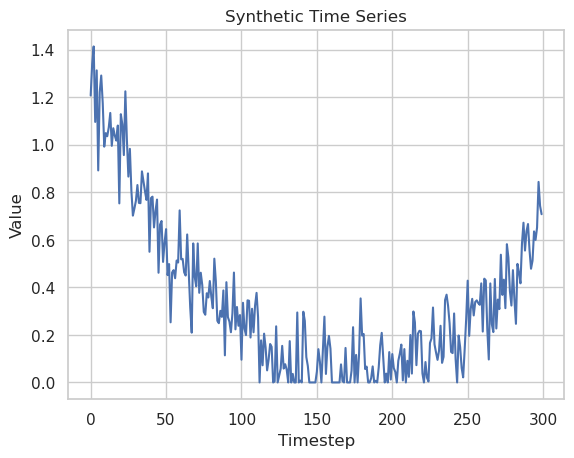

In [121]:
time_series_id = np.random.choice(df.series_id.unique(), 1)[0]
ts_df = df[df.series_id == time_series_id] # for testing
train_x = torch.tensor(ts_df["timestep"].values, dtype=torch.float32).unsqueeze(-1)  # shape [T, 1]
train_y = torch.tensor(ts_df["value"].values, dtype=torch.float32)  

plt.plot(ts_df["timestep"], ts_df["value"])
plt.title("Synthetic Time Series")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.show()

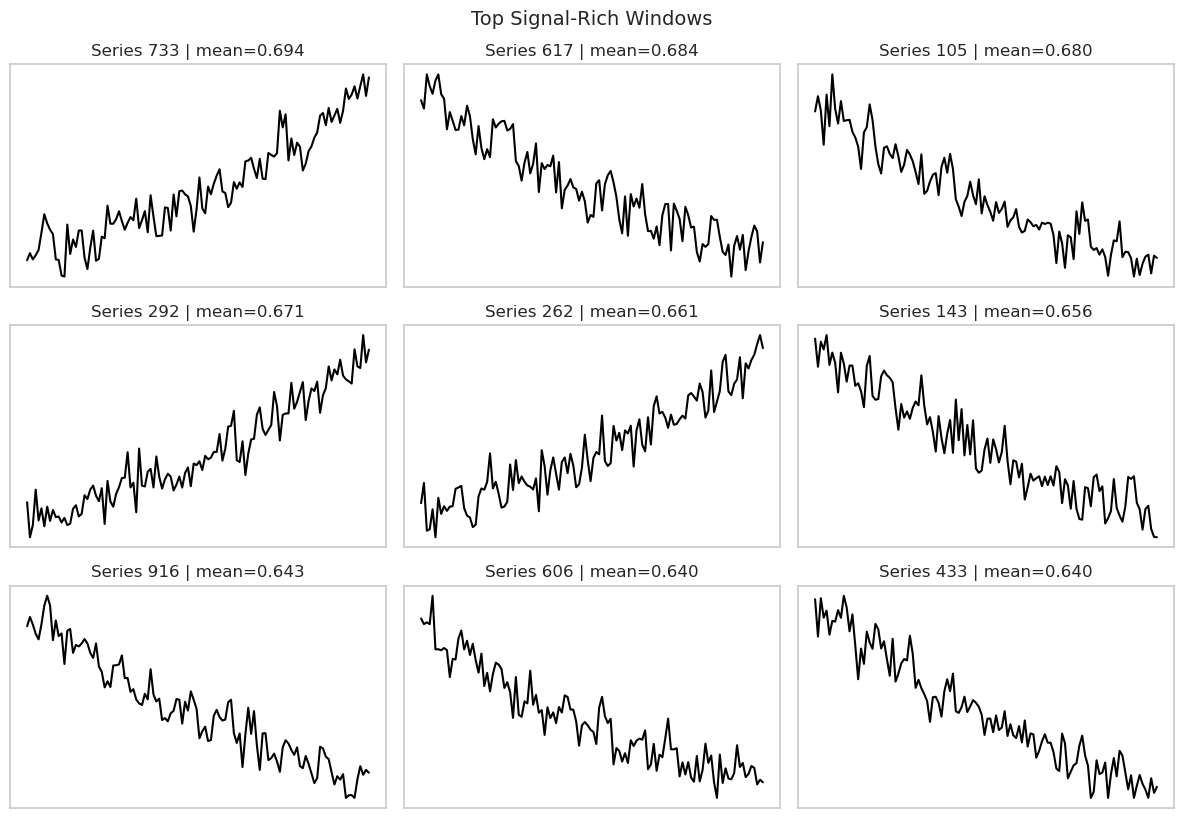

x_train shape: torch.Size([36000, 1])
y_train shape: torch.Size([36000])


In [122]:
selector = CurriculumSelector(df, window_length=120, stride=10, signal_metric="mean", top_k=300)
selector.plot_sample_slices(num_samples=9)

x_list, y_list = selector.to_tensor_dataset()

x_train = torch.cat(x_list)
y_train = torch.cat(y_list)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

In [123]:
simple_kernel_config = {
    "type": "scale",
    "outputscale": 1.0,
    "outputscale_prior": {"mean": 1.0, "stddev": 0.5},
    "base_kernel": {
        "type": "RBF",
        "lengthscale": 0.3,
        "lengthscale_prior": {"mean": 0.5, "stddev": 0.2}
    }
}



In [157]:
advanced_kernel_config = {
    "type": "add",
    "components": [
        # Long-term trend: very smooth, captures slow drift
        {
            "type": "scale",
            "outputscale": 1.0,
            "outputscale_prior": {"mean": 1.0, "stddev": 0.5},
            "base_kernel": {
                "type": "RBF",
                "lengthscale": 50.0,
                "lengthscale_prior": {"mean": 50.0, "stddev": 10.0}
            }
        },

        # Short-term trend: medium smoothness, oscillatory or local structure
        {
            "type": "scale",
            "outputscale": 1.0,
            "outputscale_prior": {"mean": 1.0, "stddev": 0.5},
            "base_kernel": {
                "type": "Matern",
                "nu": 2.5,
                "lengthscale": 8.0,
                "lengthscale_prior": {"mean": 10.0, "stddev": 3.0}
            }
        },

        # Seasonal: fixed periodic component
       # {
       #     "type": "scale",
       #     "outputscale": 0.8,
       #     "outputscale_prior": {"mean": 0.8, "stddev": 0.2},
       #     "base_kernel": {
       #         "type": "Periodic",
       #         "lengthscale": 5.0,  # Controls smoothness within a period
       #         "period_length": 12.0,
       #         "lengthscale_prior": {"mean": 5.0, "stddev": 1.0},
       #         "period_length_prior": {"mean": 12.0, "stddev": 1.0}
       #     }
       # }
    ]
}


In [158]:

# Initialize likelihood
likelihood = GaussianLikelihood()


In [159]:

model = ExactGPModel(
    train_x=train_x,
    train_y=train_y,
    likelihood=likelihood,
    kernel_config= advanced_kernel_config,
    use_mvp_kernel=False,
    mean_type="constant"
)


🔧 ExactGPModel configuration:
  • Mean       : ConstantMean
  • Kernel     : AdditiveKernel
    - Composite of : ['ScaleKernel', 'ScaleKernel']




In [160]:
# set logging level to info
logging.basicConfig(level=logging.INFO)

trainer = ExactGPTrainer(
    model=model,
    likelihood=likelihood,
    train_x=train_x,
    train_y=train_y,
    lr=0.01,
    max_grad_norm=1.0
)

trainer.train(num_epochs=100)


INFO:exact_gp_trainer:[Epoch 001] Loss: 0.927398


INFO:exact_gp_trainer:[Epoch 025] Loss: 0.757154
INFO:exact_gp_trainer:[Epoch 050] Loss: 0.561279
INFO:exact_gp_trainer:[Epoch 075] Loss: 0.352203
INFO:exact_gp_trainer:[Epoch 100] Loss: 0.139012


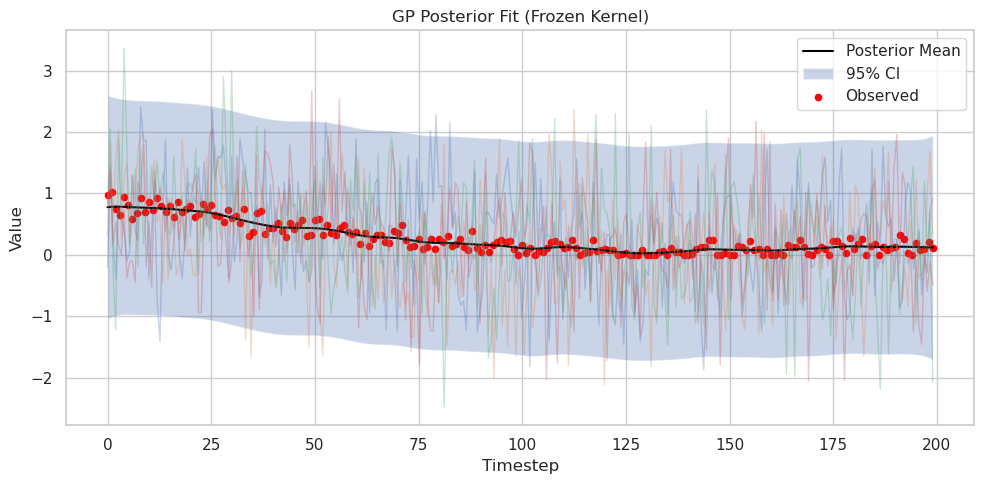

In [214]:
# Assume you already have a trained model
frozen_kernel = model.covar_module  # reuse learned kernel

# === Pick a new time series (unseen during training) ===
ts_id = np.random.choice(df.series_id.unique(), 1)[0]
ts_df_infer = df[df.series_id == ts_id].copy()

# Slice (e.g. first 200 timesteps)
ts_df_infer = ts_df_infer.iloc[:200]

x_infer = torch.tensor(ts_df_infer["timestep"].values, dtype=torch.float32).unsqueeze(-1)
y_infer = torch.tensor(ts_df_infer["value"].values, dtype=torch.float32)

# === Build predictor ===
predictor = FrozenKernelPredictor(kernel=frozen_kernel)
predictor.infer(x_infer, y_infer)

# === Create x_grid to plot over full range ===
x_plot = torch.linspace(x_infer.min(), x_infer.max(), 300).unsqueeze(-1)

# === Diagnostic plot ===
predictor.plot_fit(x_plot, show_samples=True, num_samples=4)


In [ ]:
predictor = FrozenKernelPredictor(kernel=frozen_kernel)

# Fit to new unseen slice
predictor.infer(x_infer, y_infer)

# Plot posterior
mean, lower, upper = predictor.posterior_mean_and_ci(x_plot)

# Sample from posterior
samples = predictor.sample_posterior(x_plot, num_samples=20)


In [ ]:
predictor = FrozenKernelPredictor(kernel=frozen_kernel)
predictor.infer(x_infer, y_infer)

x_plot = torch.linspace(x_infer.min(), x_infer.max(), 300).unsqueeze(-1)
predictor.plot_fit(x_plot, show_samples=True, num_samples=10)


# pre prod

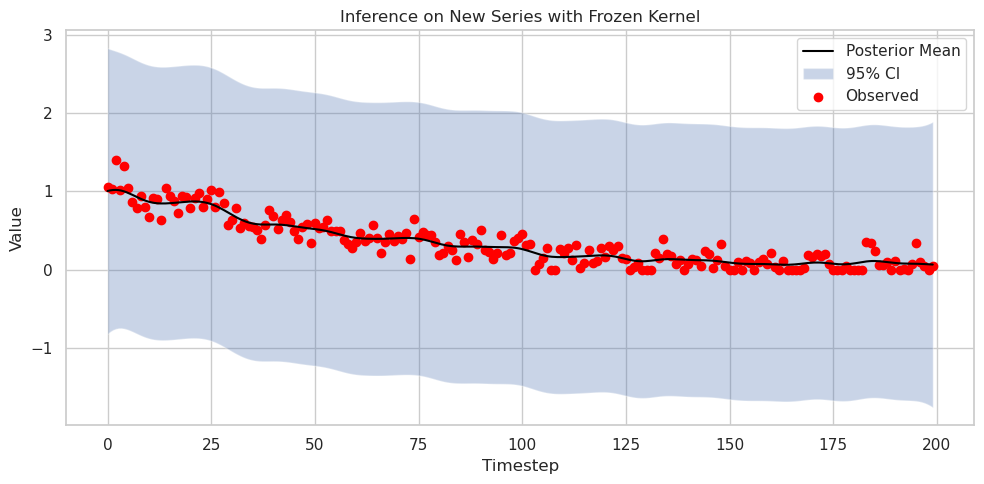

In [188]:
# get random series_id for inference
ts_ID = np.random.choice(df.series_id.unique(), 1)[0]

# Inference on different series
ts_df_infer = df[df.series_id == ts_ID]  # unseen series

# take a slio of the time series
ts_df_infer = ts_df_infer.iloc[:200]  # first 100 timesteps

x_infer = torch.tensor(ts_df_infer["timestep"].values, dtype=torch.float32).unsqueeze(-1)
y_infer = torch.tensor(ts_df_infer["value"].values, dtype=torch.float32)

# Build new model with same kernel (but no training)
frozen_kernel = model.covar_module

class FrozenKernelGP(ExactGP):
    def __init__(self, train_x, train_y, likelihood, frozen_kernel):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = frozen_kernel  # reused kernel

    def forward(self, x):
        mean = self.mean_module(x)
        cov = self.covar_module(x)
        return MultivariateNormal(mean, cov)

# Likelihood for inference
likelihood_inf = GaussianLikelihood()
gp = FrozenKernelGP(x_infer, y_infer, likelihood_inf, frozen_kernel)
gp.eval()
likelihood_inf.eval()

# Prediction
x_plot = torch.linspace(x_infer.min(), x_infer.max(), 300).unsqueeze(-1)
with torch.no_grad():
    pred = likelihood_inf(gp(x_plot))
    mean = pred.mean
    lower, upper = pred.confidence_region()

plt.figure(figsize=(10, 5))
plt.plot(x_plot.numpy(), mean.numpy(), label="Posterior Mean", color="black")
plt.fill_between(x_plot.squeeze(), lower.numpy(), upper.numpy(), alpha=0.3, label="95% CI")
plt.scatter(x_infer.numpy(), y_infer.numpy(), color='red', label="Observed")
plt.title("Inference on New Series with Frozen Kernel")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# prod

In [ ]:
generator = SyntheticTimeSeriesGenerator(
    num_series=10,
    series_length=100,
    trend_types=["long_term", "short_term", "seasonal"],
    noise_level=0.1,
    min_value=0.0,
    low_signal_ratio=0.2,
    low_signal_scale=0.02,
    seed=42
)

df = generator.generate()

dataset = TimeSeriesDataset(df, window_length=30)
print(len(dataset))  # Will be larger than num_series
print(dataset[0][0].shape)  # torch.Size([30, 1])



In [ ]:
ts_df = df[df.series_id == 0] # for testing

# Use actual time scale
train_x = torch.tensor(ts_df["timestep"].values, dtype=torch.float32).unsqueeze(-1)  # shape [T, 1]
train_y = torch.tensor(ts_df["value"].values, dtype=torch.float32)      

In [ ]:
plt.plot(ts_df["timestep"], ts_df["value"])
plt.title("Synthetic Time Series")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.show()

In [ ]:
kernel_config = {
    "type": "scale",  # Outer scale wrapper
    "outputscale": 1.0,
    "base_kernel": {
        "type": "add",
        "components": [
            {
                "type": "scale",
                "outputscale": 1.0,
                "base_kernel": {
                    "type": "RBF",
                    "lengthscale": 0.1
                }
            },
            {
                "type": "scale",
                "outputscale": 0.5,
                "base_kernel": {
                    "type": "Matern",
                    "nu": 2.5,
                    "lengthscale": 0.2
                }
            },
            {
                "type": "scale",
                "outputscale": 0.3,
                "base_kernel": {
                    "type": "Periodic",
                    "lengthscale": 0.8,
                    "period_length": 0.2
                }
            }
        ]
    }
}



#kernel_config = {
#    "type": "scale",  # global outputscale wrapper
#    "outputscale": 1.0,
#    "base_kernel": {
#        "type": "add",
#        "components": [
#            {
#                "type": "RBF",
#                "lengthscale": 0.5
#            },
#            {
#                "type": "Matern",
#                "nu": 1.5,
#                "lengthscale": 0.2
#            },
#            {
#                "type": "Periodic",
#                "lengthscale": 0.1,
#                "period_length": 0.2
#            }
#        ]
#    }
#}
#

#
#
#kernel_config = {
#    "type": "scale",
#    "outputscale": 1.0,
#    "base_kernel": {
#        "type": "RBF",
#        "lengthscale": 0.5
#    }
#}

In [ ]:
# Use real time range for inducing points
xmin = train_x.min().item()
xmax = train_x.max().item()


inducing_points = torch.linspace(xmin, xmax, 20).unsqueeze(-1)

#kernel_config = None

In [ ]:
model = VariationalGPModel(
    inducing_points=inducing_points,
    kernel_config=kernel_config,
    learn_inducing_points=True,
    mean_type="constant",
    use_mvp_kernel=False
)


# non prod


In [ ]:
# gp_train_pipeline.py

import torch
from torch.utils.data import DataLoader
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls.variational_elbo import VariationalELBO
from gp_trainer import GPTrainer
from variational_gp_model import VariationalGPModel
from inducing_point_sampler import InducingPointSampler
from gp_kernel_factory import KernelBuilder
import gp_plotting as gpplt


def train_shared_gp(
    dataset,
    kernel_config=None,
    num_inducing_points=20,
    inducing_strategy="grid",
    batch_size=4,
    num_epochs=20,
    lr=0.01,
    use_mvp_kernel=True,
    mean_type="constant",
    plot=True,
    seed=42,
):
    torch.manual_seed(seed)

    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Sample inducing points (shared across all series)
    inducer = InducingPointSampler(dataset, strategy=inducing_strategy)
    inducing_points = inducer.sample(num_inducing_points)

    # Create model and likelihood
    model = VariationalGPModel(
        inducing_points=inducing_points,
        kernel_config=kernel_config,
        mean_type=mean_type,
        learn_inducing_points=True,
        use_mvp_kernel=use_mvp_kernel
    )
    likelihood = GaussianLikelihood()

    # Create trainer
    trainer = GPTrainer(
        model=model,
        likelihood=likelihood,
        train_loader=dataloader,
        optimizer_config={"lr": lr}
    )

    # Train
    trainer.train(num_epochs=num_epochs)

    # Diagnostic plot (just on one batch)
    if plot:
        for x_batch, y_batch in dataloader:
           # gpplt.plot_posterior_fit(
           #     model=model,
           #     likelihood=likelihood,
           #     x_obs=x_batch[0],
           #     y_obs=y_batch[0],
           #     x_range=(float(x_batch[0].min()), float(x_batch[0].max())),
           #     num_samples=50
           # )
           # break
            pass

    return model, likelihood


In [ ]:
generator = SyntheticTimeSeriesGenerator(
    num_series=10,
    series_length=100,
    trend_types=["long_term", "short_term", "seasonal"],
    noise_level=0.1,
    min_value=0.0,
    low_signal_ratio=0.2,
    low_signal_scale=0.02,
    seed=42
)

df = generator.generate()

dataset = TimeSeriesDataset(df, window_length=30)
print(len(dataset))  # Will be larger than num_series
print(dataset[0][0].shape)  # torch.Size([30, 1])

ts_df = df[df.series_id == 0] # for testing

# Use actual time scale
train_x = torch.tensor(ts_df["timestep"].values, dtype=torch.float32).unsqueeze(-1)  # shape [T, 1]
train_y = torch.tensor(ts_df["value"].values, dtype=torch.float32)      

xmin = train_x.min().item()
xmax = train_x.max().item()


inducing_points = torch.linspace(xmin, xmax, 10).unsqueeze(-1)



model = VariationalGPModel(
    inducing_points=inducing_points,
    kernel_config=kernel_config,
    learn_inducing_points=True,
    mean_type="constant",
    use_mvp_kernel=False
)


model.describe()

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = torch.tensor(1e-3)

# Optimizer + MLL
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.size(0))

# Train
for epoch in range(500):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y).sum()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")


In [ ]:
ts_df = df[df.series_id == 0] # for testing

# Use actual time scale
train_x = torch.tensor(ts_df["timestep"].values, dtype=torch.float32).unsqueeze(-1)  # shape [T, 1]
train_y = torch.tensor(ts_df["value"].values, dtype=torch.float32)    


model.eval()
likelihood.eval()

# Plot over full horizon
x_plot = torch.linspace(xmin, xmax, 300).unsqueeze(-1)
with torch.no_grad():
    posterior = likelihood(model(x_plot))
    mean = posterior.mean
    lower, upper = posterior.confidence_region()

plt.figure(figsize=(10, 5))
plt.plot(x_plot.numpy(), mean.numpy(), color='black', label="Posterior Mean")
plt.fill_between(
    x_plot.squeeze(), lower.numpy(), upper.numpy(), alpha=0.2, label="95% CI"
)
plt.scatter(train_x.numpy(), train_y.numpy(), color='red', label="Observed", s=30)
plt.title("Variational GP Fit — Real Time Horizon")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Define inducing points on the same domain
inducing_points = torch.linspace(0, 100, 20).unsqueeze(-1)

In [ ]:
# === Variational GP Model ===
class MVPVariationalGP(gpytorch.models.ApproximateGP):
    def __init__(self):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)



In [ ]:


model = MVPVariationalGP()
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = torch.tensor(1e-3)

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.size(0))

# Training loop
for epoch in range(500):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y).sum()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"[{epoch:02d}] Loss: {loss.item():.4f}")


In [ ]:
model.eval()
likelihood.eval()

x_test = torch.linspace(0, 100, 200).unsqueeze(-1)
with torch.no_grad():
    preds = likelihood(model(x_test))
    mean = preds.mean
    lower, upper = preds.confidence_region()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(x_test.numpy(), mean.numpy(), label='Posterior mean', color='black')
plt.fill_between(x_test.squeeze(), lower.numpy(), upper.numpy(), alpha=0.2, label='95% CI')
plt.scatter(train_x.numpy(), train_y.numpy(), color='red', label='Observed', s=30)
plt.title("GP Fit on Synthetic Long-Term Trend")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import torch
import gpytorch
import matplotlib.pyplot as plt

# === Data ===
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(2 * torch.pi * train_x)

# Add batch dim
train_x = train_x.unsqueeze(-1)

# === Inducing points ===
inducing_points = torch.linspace(0, 1, 20).unsqueeze(-1)


# === Variational GP Model ===
class MVPVariationalGP(gpytorch.models.ApproximateGP):
    def __init__(self):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)


# === Likelihood + model ===
model = MVPVariationalGP()
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = torch.tensor(1e-3)

model.train()
likelihood.train()

# === Optimizer & Loss ===
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.size(0))

# === Training ===
for epoch in range(400):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y).sum()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"[{epoch:02d}] Loss: {loss.item():.4f}")

# === Eval ===
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 1, 200).unsqueeze(-1)

with torch.no_grad():
    pred = likelihood(model(test_x))
    mean = pred.mean
    lower, upper = pred.confidence_region()

# === Plot ===
plt.figure(figsize=(10, 5))
plt.plot(test_x.numpy(), mean.numpy(), color='black', label='Posterior mean')
plt.fill_between(test_x.squeeze().numpy(), lower.numpy(), upper.numpy(), alpha=0.2, label='95% CI')
plt.scatter(train_x.numpy(), train_y.numpy(), color='red', label='Train data', s=20)
plt.title("GPyTorch Variational GP MVP")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
generator = SyntheticTimeSeriesGenerator(
    num_series=10,
    series_length=100,
    trend_types=["long_term", "short_term", "seasonal"],
    noise_level=0.1,
    min_value=0.0,
    low_signal_ratio=0.2,
    low_signal_scale=0.02,
    seed=42
)


In [ ]:
df = generator.generate()
df.head()

In [ ]:
# Generate data
df = generator.generate()

# Create dataset (return trend components later if needed)
dataset = TimeSeriesDataset(df)

# Mini-batch 4 time series at a time
batch_size = 4
T = df['timestep'].unique().shape[0]  # Number of timesteps
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example training loop
for batch_x, batch_y in loader:
    print(batch_x.shape) #: [batch_size, T, 1]
    print(batch_y.shape) #: [batch_size, T]
    pass

# Viz Data

In [ ]:
import gp_plotting as gpplt

# Plot a single series with components
gpplt.plot_single_series(df, series_id=0)


In [ ]:
# Plot the first 4 series (just raw value)
gpplt.plot_multiple_series(df, n=4)


In [ ]:
# Visualize high vs low signal comparison
gpplt.plot_signal_vs_noise_comparison(df)

In [ ]:
gpplt.plot_component_distributions(df, component="seasonal")


In [ ]:
gpplt.plot_component_distributions(df, component="noise")


In [ ]:
class SimpleVariationalGP(ApproximateGP):
    def __init__(self, inducing_points):
        variational_dist = CholeskyVariationalDistribution(inducing_points.size(0))
        strategy = VariationalStrategy(
            self, inducing_points, variational_dist, learn_inducing_locations=True
        )
        super().__init__(strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)


In [ ]:
import torch
from torch.utils.data import DataLoader
import gpytorch
from gpytorch.mlls import VariationalELBO
import matplotlib.pyplot as plt

# -- Generate synthetic data
from time_series_generator import SyntheticTimeSeriesGenerator
from time_series_dataset import TimeSeriesDataset

generator = SyntheticTimeSeriesGenerator(
    num_series=20,
    series_length=100,
    trend_types=["long_term"],
    noise_level=0.0,
    min_value=0.0,
    seed=42
)
df = generator.generate()

# -- Dataset and loader
dataset = TimeSeriesDataset(df)
batch_size = 10
T = df['timestep'].nunique()
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# -- Inducing points
inducing_points = torch.linspace(0, 1, 20).unsqueeze(-1)

# -- Model
model = SimpleVariationalGP(inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = torch.tensor(1e-3)

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = VariationalELBO(likelihood, model, num_data=len(dataset))

# -- Training
for epoch in range(100):
    total_loss = 0
    for batch_x, batch_y in loader:
        # Flatten batch for GP
        B, T, _ = batch_x.shape
        x_batch = batch_x.view(-1, 1)
        y_batch = batch_y.view(-1)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch).sum()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"[Epoch {epoch+1:>2}] Loss: {total_loss:.4f}")


In [ ]:
# Plot posterior fit on one time series
model.eval()
likelihood.eval()

with torch.no_grad():
    x_plot = torch.linspace(0, 1, 300).unsqueeze(-1)
    pred = likelihood(model(x_plot))
    mean = pred.mean
    lower, upper = pred.confidence_region()

# Use first time series in dataset
one_series = df[df['series_id'] == 0]
x_obs = torch.tensor(one_series['timestep'].values / T, dtype=torch.float32).unsqueeze(-1)
y_obs = torch.tensor(one_series['value'].values, dtype=torch.float32)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_plot.squeeze(), mean.numpy(), label="Posterior Mean", color="black")
plt.fill_between(x_plot.squeeze(), lower.numpy(), upper.numpy(), alpha=0.2, color="blue", label="95% CI")
plt.scatter(x_obs.squeeze(), y_obs.numpy(), color="red", label="Observed", s=30)
plt.title("Minimal GP Fit — Long-Term Trend Only")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()


# Kernel

In [ ]:
kernel_config = {
    "type": "add",
    "components": [
        # Long-term trend (smooth)
        {
            "type": "scale",
            "outputscale_prior": {"mean": 1.0, "stddev": 0.3},
            "base_kernel": {
                "type": "RBF",  # very smooth
                "lengthscale_prior": {"mean": 2.0, "stddev": 0.5}
            }
        },

        # Short-term trend (less smooth)
        {
            "type": "scale",
            "outputscale_prior": {"mean": 0.5, "stddev": 0.2},
            "base_kernel": {
                "type": "Matern",
                "nu": 2.5,  # options: 0.5 (rough), 1.5, 2.5 (smoother)
                "lengthscale_prior": {"mean": 0.2, "stddev": 0.1}
            }
        },

        # Seasonal trend (periodic)
        {
            "type": "scale",
            "outputscale_prior": {"mean": 1.0, "stddev": 0.1},
            "base_kernel": {
                "type": "Periodic",
                "period_length": 0.25,
                "lengthscale_prior": {"mean": 0.3, "stddev": 0.1}
            }
        },

    ]
}



In [ ]:
# Assume kernel_config from earlier (with Matern short-term trend)
kernel = KernelBuilder(kernel_config).build()

print(kernel)
# This is now a fully usable GPyTorch kernel


In [ ]:
from gp_plotting import plot_kernel_prior_samples

plot_kernel_prior_samples(kernel_config, num_samples=10, seed=42)


# Curriculum Sampler

In [ ]:
# Create sampler
sampler = CurriculumSampler(
    dataset,
    curriculum_strength=0.05,
    max_epochs=30,
    batch_size=8,
    seed=42
)

gpplt.plot_curriculum_progression_over_epochs(
    sampler,
    dataset,
    num_batches=100,
    num_epochs=50
)

# Inducing Point Sampler

In [ ]:
# Step 1: Create dataset from your synthetic dataframe
dataset = TimeSeriesDataset(df)

# Step 2: Standard DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=8,         # full time series per batch
    shuffle=True          # optional: True if random sampling
)


In [ ]:

sampler = CurriculumSampler(
    dataset,
    curriculum_strength=0.8,
    max_epochs=30,
    batch_size=8,
    seed=42
)

# Set current epoch
sampler.set_epoch(0)

# DataLoader using our sampler
dataloader = DataLoader(
    dataset,
    batch_sampler=sampler
)

In [ ]:
inducer = InducingPointSampler(dataset, strategy="high_signal_only")
inducing_points = inducer.sample(num_points=64)  # Shape: [64, 1]

# In model:
# self.variational_strategy = VariationalStrategy(self, inducing_points, ...)


In [ ]:
for x_batch, y_batch in dataloader:
    inducing_points = inducer.sample(num_points=10)
    gpplt.plot_inducing_points_vs_inputs(x_batch, y_batch, inducing_points)
    break  # just once for inspection


# Model Class

In [ ]:
# set logging level
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info("This is an info message.")

In [ ]:
# Build GP model
model = VariationalGPModel(
    inducing_points=inducing_points,
    kernel_config=kernel_config,
    learn_inducing_points=True
)

likelihood = GaussianLikelihood()


# Training Loop

In [ ]:
generator = SyntheticTimeSeriesGenerator(
    num_series=100,
    series_length=100,
    trend_types=["long_term", "short_term", "seasonal"],
    noise_level=0.1,
    min_value=0.0,
    low_signal_ratio=0.0,
    low_signal_scale=0.2,
    seed=42
)

df = generator.generate()


sampler = CurriculumSampler(
    dataset,
    curriculum_strength=0.1,
    max_epochs=100,
    batch_size=32,
    seed=42
)

# Set current epoch
sampler.set_epoch(0)


dataset = TimeSeriesDataset(df)
#dataloader = DataLoader(dataset, batch_sampler = sampler)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

inducer = InducingPointSampler(dataset, strategy="grid") # ['random', 'high_signal_only', 'grid'
inducing_points = inducer.sample(num_points=64)



In [ ]:
#kernel_config = {
#    "type": "add",
#    "components": [
#        # Long-term trend
#        {
#            "type": "scale",
#            "outputscale_prior": {"mean": 1.0, "stddev": 0.3},
#            "base_kernel": {
#                "type": "RBF",
#                "lengthscale_prior": {"mean": 2.0, "stddev": 0.5}
#            }
#        },
#        # Short-term trend
#        {
#            "type": "scale",
#            "outputscale_prior": {"mean": 0.5, "stddev": 0.2},
#            "base_kernel": {
#                "type": "Matern",
#                "nu": 2.5,
#                "lengthscale_prior": {"mean": 0.2, "stddev": 0.1}
#            }
#        },
#        # Seasonal trend
#        {
#            "type": "scale",
#            "outputscale_prior": {"mean": 1.0, "stddev": 0.1},
#            "base_kernel": {
#                "type": "Periodic",
#                "period_length": 0.25,
#                "lengthscale_prior": {"mean": 0.3, "stddev": 0.1}
#            }
#        },
#
#    ]
#}
#


In [ ]:
kernel_config = {
    "type": "scale",
    "base_kernel": {
        "type": "RBF",
        "lengthscale": 0.3,
        "lengthscale_prior": {"mean": 3, "stddev": 1}
    },
    "outputscale": 1.0,
    "outputscale_prior": {"mean": 1.0, "stddev": 0.2}
}


In [ ]:
model = VariationalGPModel(inducing_points, kernel_config)
likelihood = GaussianLikelihood()
likelihood.noise = torch.tensor(1e-1)  # optional: initialize

VariationalGPModel.check_K_zz(model)

trainer = GPTrainer(
    model=model,
    likelihood=likelihood,
    train_loader=dataloader,
    optimizer_config={"lr": 0.01}
)

trainer.train(num_epochs=50, checkpoint_path="checkpoints/gp_model/")


In [ ]:
def plot_posterior_fit(model, likelihood, x_obs, y_obs, x_range=None, num_samples=30):
    import torch
    import matplotlib.pyplot as plt
    import seaborn as sns

    model.eval()
    likelihood.eval()

    if x_range is None:
        xmin, xmax = x_obs.min().item(), x_obs.max().item()
    else:
        xmin, xmax = x_range

    x_plot = torch.linspace(xmin, xmax, 100).unsqueeze(-1)

    with torch.no_grad(), torch.autocast("cpu"):
        posterior = likelihood(model(x_plot))
        mean = posterior.mean
        lower, upper = posterior.confidence_region()
        samples = posterior.rsample(torch.Size([num_samples]))

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 5))

    # Posterior samples
    for i in range(num_samples):
        plt.plot(x_plot.squeeze(), samples[i].numpy(), alpha=0.1, color="blue")

    # Posterior mean + CI
    plt.plot(x_plot.squeeze(), mean.numpy(), color="black", lw=2, label="Posterior Mean")
    plt.fill_between(
        x_plot.squeeze(), lower.numpy(), upper.numpy(), color="blue", alpha=0.2, label="95% CI"
    )

    # Observations
    plt.scatter(x_obs.squeeze(), y_obs, color="red", label="Observed", s=40)

    plt.title("GP Posterior Fit Check")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# One batch from your training set
x_batch, y_batch = next(iter(dataloader))

# For batch size 1 (one full time series)
plot_posterior_fit(model, likelihood, x_batch[0], y_batch[0])


In [ ]:
loader = DataLoader(dataset, batch_size=1, shuffle=True)
x_train, y_train = next(iter(loader))

gpplt.plot_gp_diagnostics(
    model=model,
    likelihood=likelihood,
    num_samples=5,
    include_data=(x_train[0], y_train[0]),
    x_range=(0, 100),
    posterior=True,
)


# Sanity check

In [ ]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.models import ApproximateGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import VariationalELBO
from torch.utils.data import TensorDataset, DataLoader

# ----- Setup reproducibility
torch.manual_seed(42)

# ----- 1. Generate one clean synthetic series
T = 100
x = torch.linspace(0, 1, T).unsqueeze(-1)
long = torch.sin(2 * torch.pi * 0.5 * x)
short = torch.sin(2 * torch.pi * 5 * x)
seasonal = torch.sin(2 * torch.pi * 3 * x + 0.5)
y = long + 0.5 * short + 0.3 * seasonal
y += 0.05 * torch.randn_like(y)  # small noise

# ----- 2. Inducing points (grid)
inducing_points = torch.linspace(0, 1, 20).unsqueeze(-1)

# ----- 3. Define kernel
def build_kernel():
    k1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    k2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
    k3 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
    return gpytorch.kernels.AdditiveKernel(k1, k2, k3)

# ----- 4. Define GP model
class SanityGP(ApproximateGP):
    def __init__(self, inducing_points):
        variational_dist = CholeskyVariationalDistribution(inducing_points.size(0))
        strategy = VariationalStrategy(self, inducing_points, variational_dist, learn_inducing_locations=True)
        super().__init__(strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = build_kernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# ----- 5. Instantiate model
model = SanityGP(inducing_points)
likelihood = GaussianLikelihood()
likelihood.noise = torch.tensor(1e-2)

# ----- 6. DataLoader
dataset = TensorDataset(x, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# ----- 7. Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = VariationalELBO(likelihood, model, num_data=len(x))

# ----- 8. Train loop
model.train()
likelihood.train()
for epoch in range(100):
    total_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = -mll(output, yb).sum()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"[Epoch {epoch:>3}] Loss: {total_loss:.4f}")

# ----- 9. Evaluation
model.eval()
likelihood.eval()

with torch.no_grad():
    x_test = torch.linspace(0, 1, 300).unsqueeze(-1)
    preds = likelihood(model(x_test))
    mean = preds.mean
    lower, upper = preds.confidence_region()

    samples = preds.rsample(torch.Size([30]))

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Samples
for i in range(30):
    plt.plot(x_test.squeeze(), samples[i].numpy(), alpha=0.1, color='blue')

# Mean and CI
plt.plot(x_test.squeeze(), mean.numpy(), color='black', lw=2, label="Posterior Mean")
plt.fill_between(x_test.squeeze(), lower.numpy(), upper.numpy(), alpha=0.2, color="blue", label="95% CI")

# Observed
plt.scatter(x.squeeze(), y.squeeze(), color="red", label="Observed", s=30)

plt.title("Sanity GP Posterior Fit")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

## ----- 10. Kernel diagnostics
#print("\n=== Kernel Structure and Parameters ===")
#def print_kernel(k, indent=0):
#    space = "  " * indent
#    if hasattr(k, "base_kernel"):
#        print_kernel(k.base_kernel, indent + 1)
#    elif hasattr(k, "kernels"):
#        for i, sub in enumerate(k.kernels):
#            print(f"{space}[Component {i}]")
#            print_kernel(sub, indent + 1)
#    else:
#        print(f"{space}{k.__class__.__name__}")
#    if hasattr(k, "lengthscale"):
#        print(f"{space}lengthscale: {k.lengthscale.detach().cpu().numpy()}")
#    if hasattr(k, "outputscale"):
#        print(f"{space}outputscale: {k.outputscale.detach().cpu().numpy()}")
#print_kernel(model.covar_module)
#

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch


def plot_posterior_fit(model, likelihood, x_obs, y_obs, x_range=None, num_samples=30):
    """
    Plot GP posterior fit: mean, samples, confidence, and training points.

    Parameters
    ----------
    model : Trained VariationalGPModel
    likelihood : Corresponding likelihood (e.g. GaussianLikelihood)
    x_obs : torch.Tensor
        Training inputs (shape: [T, 1])
    y_obs : torch.Tensor
        Training targets (shape: [T])
    x_range : tuple, optional
        Range for plotting (defaults to min/max of x_obs)
    num_samples : int
        Number of posterior function samples to draw
    """
    model.eval()
    likelihood.eval()

    if x_range is None:
        xmin, xmax = x_obs.min().item(), x_obs.max().item()
    else:
        xmin, xmax = x_range

    x_plot = torch.linspace(xmin, xmax, 200).unsqueeze(-1)

    with torch.no_grad(), torch.autocast("cpu"), torch.no_grad():
        posterior = likelihood(model(x_plot))
        mean = posterior.mean
        lower, upper = posterior.confidence_region()

        samples = posterior.rsample(torch.Size([num_samples]))

    x_np = x_plot.squeeze().cpu().numpy()

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    # Plot samples
    for i in range(num_samples):
        plt.plot(x_np, samples[i].cpu().numpy(), color="blue", alpha=0.1)

    # Plot mean and CI
    plt.plot(x_np, mean.cpu().numpy(), color="black", linewidth=2, label="Posterior Mean")
    plt.fill_between(
        x_np, lower.cpu().numpy(), upper.cpu().numpy(), color="blue", alpha=0.2, label="Confidence Region"
    )

    # Plot observed points
    plt.scatter(x_obs.squeeze().cpu(), y_obs.cpu(), color="red", zorder=10, s=40, label="Training Points")

    plt.title("Gaussian Process Posterior Fit")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
x_batch, y_batch = next(iter(dataloader))  # or use a specific series

#gpplt.plot_posterior_fit(
plot_posterior_fit(
    model=model,
    likelihood=likelihood,
    x_obs=x_batch[0],
    y_obs=y_batch[0],
    num_samples=50,
    x_range=(0, 100)  # Adjust as needed
)


In [ ]:

x_test = torch.linspace(0, 1, 200).unsqueeze(-1)
components = extract_latent_components(model, x_test, use_mean=True)

# Plot
import matplotlib.pyplot as plt

for i, f in components.items():
    plt.plot(x_test.numpy(), f.numpy(), label=f"Component {i}")

plt.title("Latent Trend Components")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()



In [ ]:
# test on one series form the dataset
x_test = torch.linspace(0, 100, 200).unsqueeze(-1)
x_train, y_train = next(iter(loader))
components = extract_latent_components(model, x_test, use_mean=True)
# Plot
import matplotlib.pyplot as plt
for i, f in components.items():
    plt.plot(x_test.numpy(), f.numpy(), label=f"Component {i}")
    plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label="Data", alpha=0.5)
plt.title("Latent Trend Components")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import torch
from gp_utils import extract_latent_components


def infer_latent_dataframe(model, dataset, component_names=None, use_mean=True, seed=None):
    """
    Infer full latent trend + components for each time series in a dataset.

    Parameters
    ----------
    model : VariationalGPModel
        Trained GP model.
    dataset : TimeSeriesDataset
        Dataset that returns (x, y) and has .series_groups (a list of DataFrames).
    component_names : list[str], optional
        Names for each kernel component (e.g., ["long_term", "short_term", "seasonal"])
    use_mean : bool
        Whether to use mean (True) or sampled trends (False).
    seed : int, optional
        For reproducibility when sampling.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns:
        ['series_id', 'timestep', 'value', 'trend_full', 'trend_<component_1>', ...]
    """
    if not hasattr(dataset, "series_groups"):
        raise ValueError("Dataset must have a `series_groups` attribute (e.g. list of DataFrames)")

    all_records = []

    for series_id, group_df in enumerate(dataset.series_groups):
        x = torch.tensor(group_df["timestep"].values, dtype=torch.float32).unsqueeze(-1)
        y = torch.tensor(group_df["value"].values, dtype=torch.float32)

        model.eval()
        with torch.no_grad():
            post = model(x)
            full_mean = post.mean.detach().cpu()

        components = extract_latent_components(model, x, use_mean=use_mean, seed=seed)

        for i in range(len(x)):
            row = {
                "series_id": series_id,
                "timestep": int(group_df["timestep"].iloc[i]),
                "value": y[i].item(),
                "trend_full": full_mean[i].item(),
            }

            for k, f in components.items():
                cname = (
                    component_names[k]
                    if component_names and k < len(component_names)
                    else f"trend_component_{k}"
                )
                row[cname] = f[i].item()

            all_records.append(row)

    return pd.DataFrame(all_records)


In [ ]:
trend_df = infer_latent_dataframe(
    model=model,
    dataset=dataset,
    component_names=["long_term", "short_term", "seasonal"],
    use_mean=True,
)

In [ ]:
trend_df["series_id"].unique()

In [ ]:
trend_df.head()

In [ ]:
trend_df.head()
# subset to one series ID for visualization

series_id = 0
subset_df = trend_df[trend_df["series_id"] == series_id].copy()
subset_df = subset_df.sort_values("timestep")
# Plot the trends

plt.figure(figsize=(12, 6))
plt.scatter(subset_df["timestep"], subset_df["value"], label="Observed", alpha=0.5)
plt.plot(subset_df["timestep"], subset_df["trend_full"], label="Full Trend", color="blue")

In [ ]:

def infer_latent_dataframe(model, dataset, component_names=None, use_mean=True, seed=None):
    """
    Infer full latent trend + components for each time series in a dataset.

    Parameters
    ----------
    model : VariationalGPModel
        Trained GP model.
    dataset : TimeSeriesDataset
        Dataset that returns (x, y) and has .series_groups attribute.
    component_names : list[str], optional
        Names for each kernel component (e.g., ["long_term", "short_term", "seasonal"])
    use_mean : bool
        Whether to use mean (True) or sampled trends (False).
    seed : int, optional
        For reproducibility when sampling.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns:
        ['series_id', 'timestep', 'value', 'trend_full', 'trend_component_1', ...]
    """
    all_records = []

    for series_id, group_df in dataset.series_groups.items():
        x = torch.tensor(group_df["timestep"].values, dtype=torch.float32).unsqueeze(-1)
        y = torch.tensor(group_df["value"].values, dtype=torch.float32)

        # Inferred full trend (posterior mean)
        model.eval()
        with torch.no_grad():
            post = model(x)
            full_mean = post.mean.detach().cpu()

        # Extract component-wise latent trends
        components = extract_latent_components(model, x, use_mean=use_mean, seed=seed)

        for i in range(len(x)):
            row = {
                "series_id": series_id,
                "timestep": int(group_df["timestep"].iloc[i]),
                "value": y[i].item(),
                "trend_full": full_mean[i].item(),
            }

            for k, f in components.items():
                cname = (
                    component_names[k]
                    if component_names and k < len(component_names)
                    else f"trend_component_{k}"
                )
                row[cname] = f[i].item()

            all_records.append(row)

    return pd.DataFrame(all_records)


In [ ]:
import pandas as pd
import torch
from gp_utils import extract_latent_components


def infer_latent_dataframe(model, dataset, component_names=None, use_mean=True, seed=None):
    """
    Infer full latent trend + components for each time series in a dataset.

    Parameters
    ----------
    model : VariationalGPModel
        Trained GP model.
    dataset : TimeSeriesDataset
        Dataset that returns (x, y) and has .series_groups attribute (list of (series_id, df)).
    component_names : list[str], optional
        Names for each kernel component (e.g., ["long_term", "short_term", "seasonal"])
    use_mean : bool
        Whether to use mean (True) or sampled trends (False).
    seed : int, optional
        For reproducibility when sampling.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns:
        ['series_id', 'timestep', 'value', 'trend_full', 'trend_<component_1>', ...]
    """
    if not hasattr(dataset, "series_groups"):
        raise ValueError("Dataset must have a `series_groups` attribute (e.g. list of (series_id, DataFrame))")

    all_records = []

    for series_id, group_df in dataset.series_groups:
        x = torch.tensor(group_df["timestep"].values, dtype=torch.float32).unsqueeze(-1)
        y = torch.tensor(group_df["value"].values, dtype=torch.float32)

        model.eval()
        with torch.no_grad():
            post = model(x)
            full_mean = post.mean.detach().cpu()

        components = extract_latent_components(model, x, use_mean=use_mean, seed=seed)

        for i in range(len(x)):
            row = {
                "series_id": series_id,
                "timestep": int(group_df["timestep"].iloc[i]),
                "value": y[i].item(),
                "trend_full": full_mean[i].item(),
            }

            for k, f in components.items():
                cname = (
                    component_names[k]
                    if component_names and k < len(component_names)
                    else f"trend_component_{k}"
                )
                row[cname] = f[i].item()

            all_records.append(row)

    return pd.DataFrame(all_records)


In [ ]:
trend_df = infer_latent_dataframe(
    model=model,
    dataset=dataset,
    component_names=["long_term", "short_term", "seasonal"],
    use_mean=True,
)

print(trend_df.head())


In [ ]:
# from gp_utils import infer_latent_dataframe

component_names = ["long_term", "short_term", "seasonal"]

trend_df = infer_latent_dataframe(
    model=model,
    dataset=dataset,
    component_names=component_names,
    use_mean=True,
)

print(trend_df.head())
